# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

Distillation is a technique used to transfer knowledge from a large, complex model (often called the teacher model) to a smaller, simpler model (the student model). The goal of distillation is to create a smaller, more efficient model that can achieve similar performance to the larger model but with fewer parameters and lower computational cost. This approach is particularly useful for deploying models in environments with limited resources, such as on mobile devices or in real-time applications

In [3]:
import torch
import datasets
import transformers
from datasets import DatasetDict

datasets.__version__, transformers.__version__, torch.__version__

('3.4.1', '4.49.0', '2.6.0+cu124')

In [4]:
import torch.nn as nn
import random, math, time
from tqdm.auto import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Load and Split Dataset

In [5]:
raw_datasets = datasets.load_dataset('AiresPucrs/toxic-comments')
raw_datasets

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/536 [00:00<?, ?B/s]

toxic_content_dataset.csv:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/70157 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 70157
    })
})

In [6]:
raw_datasets['train'][0]

{'comment_text': 'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired',
 'toxic': 1}

In [7]:
raw_datasets['train'][-5465]

{'comment_text': 'suck asshole less life fuck horse shitbag', 'toxic': 0}

In [8]:
# In this dataset 0 means toxic and 1 means no-toxic
label2id = {'toxic': 0, 'no_toxic': 1}
id2label = {0: 'toxic', 1: 'no_toxic'}

In [9]:
train_validtest = raw_datasets['train'].train_test_split(test_size=0.3)
train_validtest

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 49109
    })
    test: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 21048
    })
})

In [10]:
test_valid  = train_validtest['test'].train_test_split(test_size=0.5)
test_valid

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 10524
    })
    test: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 10524
    })
})

In [11]:
splitted_datasets = DatasetDict({
    'train': train_validtest['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})
splitted_datasets

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 49109
    })
    validation: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 10524
    })
    test: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 10524
    })
})

In [12]:
## save the spliited dataset for the future evaluation
splitted_datasets.save_to_disk('splitted_datasets')

In [ ]:
!zip -r splitted_datasets.zip splitted_datasets/

## 2. Model & Tokenization

In [13]:
import numpy as np
num_labels = np.unique(raw_datasets['train']['toxic']).size
num_labels

2

In [14]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 3. Preprocessing

In [15]:
tokenizer('I want to get peace', max_length=128, truncation=True)

{'input_ids': [101, 1045, 2215, 2000, 2131, 3521, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [16]:
def preprocess_function(raw_data):
    result = tokenizer(raw_data['comment_text'], max_length=128, truncation=True)
    return result

In [17]:
tokenized_datasets = splitted_datasets.map(preprocess_function, batched=True, remove_columns=['comment_text'])
tokenized_datasets = tokenized_datasets.rename_column("toxic", "labels")
tokenized_datasets

Map:   0%|          | 0/49109 [00:00<?, ? examples/s]

Map:   0%|          | 0/10524 [00:00<?, ? examples/s]

Map:   0%|          | 0/10524 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 49109
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10524
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10524
    })
})

### Visualize Classes

In [19]:
from collections import Counter

labels = [int(label) for label in tokenized_datasets["train"]["labels"]]
label_counts = Counter(labels)
label_counts

Counter({0: 24662, 1: 24447})

<Axes: >

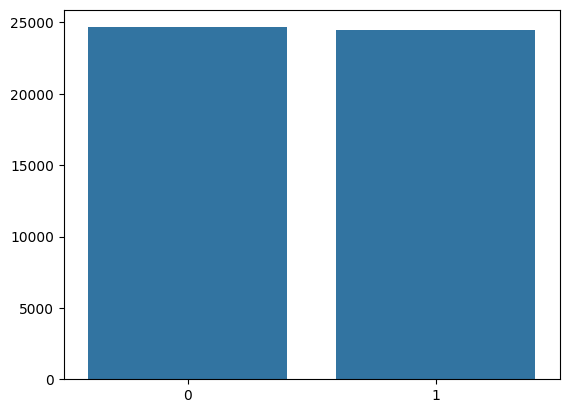

In [20]:
import seaborn as sns


sns.barplot(label_counts)

According to the plot, the counts for label 0 and label 1 are nearly equal. I turst it is okay to use it.

In [21]:
tokenized_datasets['train'][0]['input_ids']

[101, 3280, 4456, 102]

In [22]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] die cancer [SEP]'

## 4. Preparing the dataloader

In [23]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [24]:
train_dataset = tokenized_datasets["train"].shuffle(seed=1150)
eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150)
test_dataset = tokenized_datasets["test"].shuffle(seed=1150)

In [25]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=32, collate_fn=data_collator)

In [26]:
for batch in train_dataloader:
    break

batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture
In the present work, the student - DistilBERT - has the same general architecture as BERT.
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2.
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers.
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher).
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [27]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "toxic",
    "1": "no_toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "no_toxic": 1,
    "toxic": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

####
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [28]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [29]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [30]:
# Student model for even layers
student_model_even = type(teacher_model)(configuration)

# Student model for odd layers
student_model_odd = type(teacher_model)(configuration)

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [31]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher: Module,
    student: Module,
    layer_type: str  # 'even' or 'odd'
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, layer_type)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers
        for i in range(len(student_encoding_layers)):
            if layer_type == 'even':
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2 * i].state_dict())
            elif layer_type == 'odd':
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2 * i + 1].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return student

In [32]:
# Distill weights for even layers
student_model_even = distill_bert_weights(teacher_model, student_model_even, layer_type='even')

# Distill weights for odd layers
student_model_odd = distill_bert_weights(teacher_model, student_model_odd, layer_type='odd')

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student Even parameters :', count_parameters(student_model_even))
print('Student Odd parameters :', count_parameters(student_model_odd))

Teacher parameters : 109483778
Student Even parameters : 66956546
Student Odd parameters : 66956546


In [34]:
count_parameters(student_model_even)/count_parameters(teacher_model) * 100

61.156590705154514

In [35]:
student_model_even.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "toxic",
    "1": "no_toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "no_toxic": 1,
    "toxic": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [36]:
student_model_odd.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "toxic",
    "1": "no_toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "no_toxic": 1,
    "toxic": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [37]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities!
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits
        '''
        T = temperature #.cuda()

        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T

        return KD_loss

In [38]:
even_criterion_div = DistillKL()
even_criterion_cos = nn.CosineEmbeddingLoss()

odd_criterion_div = DistillKL()
odd_criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [39]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
even_optimizer = optim.Adam(params=student_model_even.parameters(), lr=lr)
odd_optimizer = optim.Adam(params=student_model_odd.parameters(), lr=lr)

In [40]:
student_model_even = student_model_even.to(device)
student_model_odd = student_model_odd.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [41]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

even_lr_scheduler = get_scheduler(
    name="linear",
    optimizer=even_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

odd_lr_scheduler = get_scheduler(
    name="linear",
    optimizer=odd_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

## 8. Metric

In [43]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00


In [44]:
import numpy as np
import evaluate
# Get the metric function

even_metric = evaluate.load("accuracy")
odd_metric = evaluate.load("accuracy")

## 9. Train Even Student Model

In [45]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

# Lists to store losses for each epoch
train_losses = []
train_losses_cls = []
train_losses_div = []
train_losses_cos = []
eval_losses = []

for epoch in range(num_epochs):
    student_model_even.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = student_model_even(**batch)
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()

        # cls loss
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = even_criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = even_criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()

        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3

        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        even_optimizer.step()
        even_lr_scheduler.step()
        even_optimizer.zero_grad()
        progress_bar.update(1)

    train_losses.append(train_loss / len(train_dataloader))
    train_losses_cls.append(train_loss_cls / len(train_dataloader))
    train_losses_div.append(train_loss_div / len(train_dataloader))
    train_losses_cos.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

    student_model_even.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = student_model_even(**batch)

        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        even_metric.add_batch(
            predictions=predictions,
            references=batch["labels"])

    eval_metric = even_metric.compute()
    eval_metrics += eval_metric['accuracy']
    eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting

    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")

print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/7675 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.1805:
  - Loss_cls: 0.3749
  - Loss_div: 0.1115
  - Loss_cos: 0.0550
Epoch at 1: Test Acc 0.9498
Epoch at 2: Train loss 0.1691:
  - Loss_cls: 0.3343
  - Loss_div: 0.1252
  - Loss_cos: 0.0477
Epoch at 2: Test Acc 0.9494
Epoch at 3: Train loss 0.1634:
  - Loss_cls: 0.3137
  - Loss_div: 0.1317
  - Loss_cos: 0.0447
Epoch at 3: Test Acc 0.9534
Epoch at 4: Train loss 0.1604:
  - Loss_cls: 0.3033
  - Loss_div: 0.1350
  - Loss_cos: 0.0428
Epoch at 4: Test Acc 0.9478
Epoch at 5: Train loss 0.1589:
  - Loss_cls: 0.2986
  - Loss_div: 0.1365
  - Loss_cos: 0.0417
Epoch at 5: Test Acc 0.9509
Avg Metric 0.9502850627137971


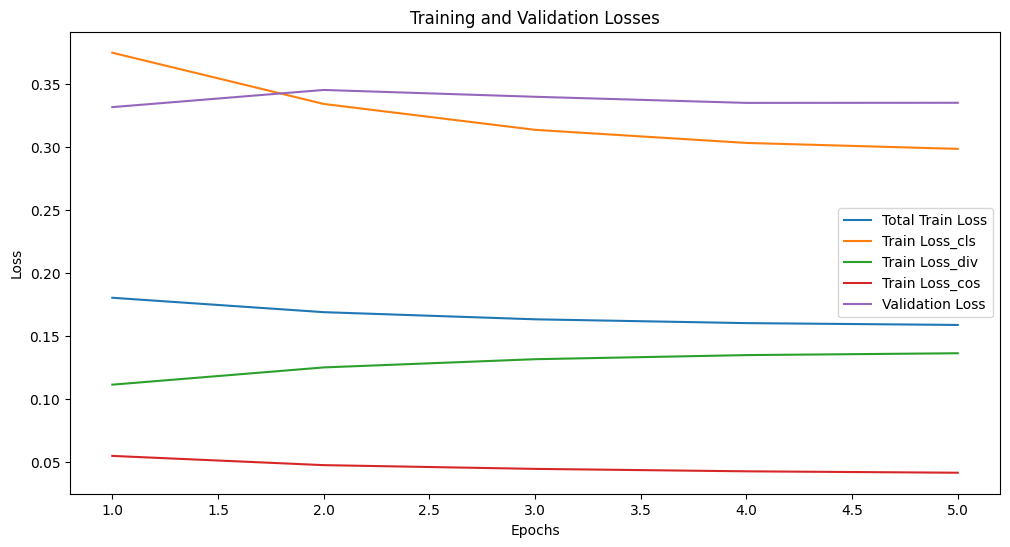

In [46]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Save the student model with even layers
student_model_even.save_pretrained('student_model_even')

In [48]:
!zip -r student_model_even.zip student_model_even/

  adding: student_model_even/ (stored 0%)
  adding: student_model_even/config.json (deflated 50%)
  adding: student_model_even/model.safetensors (deflated 8%)


## 10. Train Odd Student Model

In [49]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

# Lists to store losses for each epoch
train_losses = []
train_losses_cls = []
train_losses_div = []
train_losses_cos = []
eval_losses = []

for epoch in range(num_epochs):
    student_model_odd.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = student_model_odd(**batch)
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()

        # cls loss
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = odd_criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = odd_criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()

        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3

        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        odd_optimizer.step()
        odd_lr_scheduler.step()
        odd_optimizer.zero_grad()
        progress_bar.update(1)

    train_losses.append(train_loss / len(train_dataloader))
    train_losses_cls.append(train_loss_cls / len(train_dataloader))
    train_losses_div.append(train_loss_div / len(train_dataloader))
    train_losses_cos.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

    student_model_odd.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = student_model_odd(**batch)

        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        odd_metric.add_batch(
            predictions=predictions,
            references=batch["labels"])

    eval_metric = odd_metric.compute()
    eval_metrics += eval_metric['accuracy']
    eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting

    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")

print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/7675 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.1807:
  - Loss_cls: 0.3785
  - Loss_div: 0.1090
  - Loss_cos: 0.0546
Epoch at 1: Test Acc 0.9513
Epoch at 2: Train loss 0.1694:
  - Loss_cls: 0.3374
  - Loss_div: 0.1234
  - Loss_cos: 0.0475
Epoch at 2: Test Acc 0.9488
Epoch at 3: Train loss 0.1641:
  - Loss_cls: 0.3172
  - Loss_div: 0.1303
  - Loss_cos: 0.0447
Epoch at 3: Test Acc 0.9498
Epoch at 4: Train loss 0.1606:
  - Loss_cls: 0.3049
  - Loss_div: 0.1343
  - Loss_cos: 0.0427
Epoch at 4: Test Acc 0.9497
Epoch at 5: Train loss 0.1590:
  - Loss_cls: 0.2995
  - Loss_div: 0.1361
  - Loss_cos: 0.0415
Epoch at 5: Test Acc 0.9503
Avg Metric 0.9499809958190802


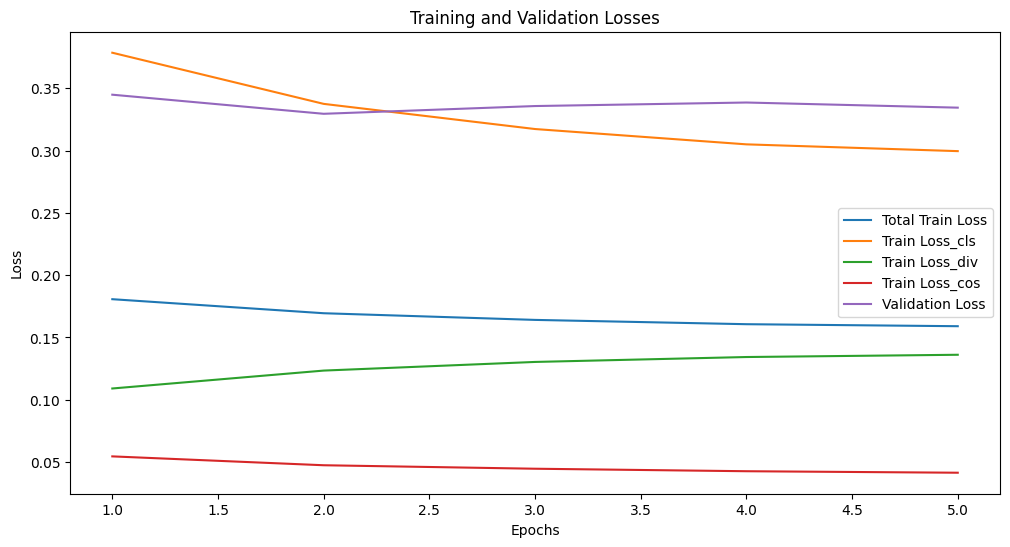

In [50]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
# Save the student model with odd layers
student_model_odd.save_pretrained('student_model_odd')

In [52]:
!zip -r student_model_odd.zip student_model_odd/

  adding: student_model_odd/ (stored 0%)
  adding: student_model_odd/config.json (deflated 50%)
  adding: student_model_odd/model.safetensors (deflated 8%)


# [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/1910.01108)

Low-Rank Adaptation (LoRA) is a technique used in machine learning, especially in the context of fine-tuning large language models (LLMs). It is a way to adapt pre-trained models to specific tasks with much fewer parameters and computational resources, making it more efficient than traditional fine-tuning approaches.

# Load Dataset and Base Model

In [53]:
import pickle
with open('tokenized_datasets.pkl', 'rb') as file:
    tokenized_datasets = pickle.load(file)

In [54]:
# In this dataset 0 means toxic and 1 means no-toxic
label2id = {'toxic': 0, 'no_toxic': 1}
id2label = {0: 'toxic', 1: 'no_toxic'}

In [55]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

base_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels = len(label2id),
    id2label = id2label,
    label2id = label2id,
)

base_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 2.  Set up LoRA Config

In [56]:
from peft import get_peft_model, LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    r=8,  # Rank of the low-rank adaptation
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1,  # Dropout for LoRA layers
    target_modules=["query", "value"]  # Target specific layers in BERT
)

model_lora = get_peft_model(base_model, lora_config)

## 3. Set Up Training Arguments

In [57]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./model_lora_checkpoints",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

In [58]:
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [59]:
from transformers import Trainer

trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## 4. Train LoRA Student Model

In [60]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: francisphone1998 (francisphone1998-asian-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.123400,0.162501,0.938902
2,0.151000,0.149952,0.941847
3,0.135200,0.139785,0.944698
4,0.128700,0.146954,0.945933
5,0.168200,0.140927,0.945743


TrainOutput(global_step=7675, training_loss=0.16248483118871135, metrics={'train_runtime': 3835.4098, 'train_samples_per_second': 64.021, 'train_steps_per_second': 2.001, 'total_flos': 1.55350706959272e+16, 'train_loss': 0.16248483118871135, 'epoch': 5.0})

In [68]:
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

{'eval_loss': 0.1475098729133606, 'eval_accuracy': 0.9465032307107564, 'eval_runtime': 71.1352, 'eval_samples_per_second': 147.944, 'eval_steps_per_second': 4.625, 'epoch': 5.0}


In [61]:
model_lora.save_pretrained("./model_lora")

In [62]:
!zip -r model_lora.zip model_lora/

  adding: model_lora/ (stored 0%)
  adding: model_lora/adapter_config.json (deflated 54%)
  adding: model_lora/README.md (deflated 66%)
  adding: model_lora/adapter_model.safetensors (deflated 7%)


## 11.  Model Evaluations and Comparisons

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel


teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)
base_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels=2  # Ensure this matches the number of labels in your task
)


# Load the student model with even layers
student_model_even = AutoModelForSequenceClassification.from_pretrained('student_model_even')

# Load the student model with odd layers
student_model_odd = AutoModelForSequenceClassification.from_pretrained('student_model_odd')

# Load bert-base-uncased model with LoRA
model_lora = PeftModel.from_pretrained(base_model, "model_lora")

C:\Users\Phone Myint Naing\anaconda3\envs\thai_cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# In this dataset 0 means toxic and 1 means no-toxic
label2id = {'toxic': 0, 'no_toxic': 1}
id2label = {0: 'toxic', 1: 'no_toxic'}

In [3]:
# Example input
inputs = tokenizer("This movie is so good!", max_length=128, truncation=True, return_tensors="pt")

# Get predictions
outputs = student_model_even(**inputs)
predictions = outputs.logits.argmax(dim=-1)
print(id2label[int(predictions)])

no_toxic


In [4]:
# Example input
inputs = tokenizer("This movie is a shit!", max_length=128, truncation=True, return_tensors="pt")

# Get predictions
outputs = student_model_even(**inputs)
predictions = outputs.logits.argmax(dim=-1)
print(id2label[int(predictions)])

toxic


In [5]:
# Example input
inputs = tokenizer("I hate you", max_length=128, truncation=True, return_tensors="pt")

# Get predictions
outputs = student_model_odd(**inputs)
predictions = outputs.logits.argmax(dim=-1)
print(id2label[int(predictions)])

toxic


In [6]:
# Example input
inputs = tokenizer("I love you", max_length=128, truncation=True, return_tensors="pt")

# Get predictions
outputs = student_model_odd(**inputs)
predictions = outputs.logits.argmax(dim=-1)
print(id2label[int(predictions)])

no_toxic


In [7]:
# Example input
inputs = tokenizer("You, son of the bitch", max_length=128, truncation=True, return_tensors="pt")

# Get predictions
outputs = model_lora(**inputs)
predictions = outputs.logits.argmax(dim=-1)
print(id2label[int(predictions)])

toxic


In [8]:
# Example input
inputs = tokenizer("I don't really care", max_length=128, truncation=True, return_tensors="pt")

# Get predictions
outputs = model_lora(**inputs)
predictions = outputs.logits.argmax(dim=-1)
print(id2label[int(predictions)])

no_toxic


In [12]:
from datasets import Dataset, DatasetDict

splitted_datasets = DatasetDict.load_from_disk('splitted_datasets/')
splitted_datasets

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 49109
    })
    validation: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 10524
    })
    test: Dataset({
        features: ['comment_text', 'toxic'],
        num_rows: 10524
    })
})

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [27]:
# Even Layers Student Model
predictions = []
for test in tqdm(splitted_datasets['test']):
    inputs = tokenizer(test['comment_text'], max_length=128, truncation=True, return_tensors="pt")
    outputs = student_model_even(**inputs)
    prediction = outputs.logits.argmax(dim=-1)
    predictions.append(int(prediction))

print('Even Layers Student Model')
print('Accuracy:', accuracy_score(splitted_datasets['test']['toxic'], predictions))
print('Precision:', precision_score(splitted_datasets['test']['toxic'], predictions))
print('Recall:', recall_score(splitted_datasets['test']['toxic'], predictions))
print('F1 Score:', f1_score(splitted_datasets['test']['toxic'], predictions))

100%|████████████████████████████████████████████████████████████████████████████| 10524/10524 [18:27<00:00,  9.50it/s]

Even Layers Student Model
Accuracy: 0.9855568225009502
Precision: 0.9855099736544976
Recall: 0.9858810240963856
F1 Score: 0.9856954639563336


In [28]:
# Odd Layers Student Model
predictions = []
for test in tqdm(splitted_datasets['test']):
    inputs = tokenizer(test['comment_text'], max_length=128, truncation=True, return_tensors="pt")
    outputs = student_model_odd(**inputs)
    prediction = outputs.logits.argmax(dim=-1)
    predictions.append(int(prediction))

print('Odd Layers Student Model')
print('Accuracy:', accuracy_score(splitted_datasets['test']['toxic'], predictions))
print('Precision:', precision_score(splitted_datasets['test']['toxic'], predictions))
print('Recall:', recall_score(splitted_datasets['test']['toxic'], predictions))
print('F1 Score:', f1_score(splitted_datasets['test']['toxic'], predictions))

100%|████████████████████████████████████████████████████████████████████████████| 10524/10524 [21:36<00:00,  8.12it/s]


Odd Layers Student Model
Accuracy: 0.9861269479285443
Precision: 0.9862575301204819
Recall: 0.9862575301204819
F1 Score: 0.9862575301204819


In [29]:
# Bert-based-uncased Model with LoRA
predictions = []
for test in tqdm(splitted_datasets['test']):
    inputs = tokenizer(test['comment_text'], max_length=128, truncation=True, return_tensors="pt")
    outputs = model_lora(**inputs)
    prediction = outputs.logits.argmax(dim=-1)
    predictions.append(int(prediction))

print('Bert-base-uncased Model with LoRA')
print('Accuracy:', accuracy_score(splitted_datasets['test']['toxic'], predictions))
print('Precision:', precision_score(splitted_datasets['test']['toxic'], predictions))
print('Recall:', recall_score(splitted_datasets['test']['toxic'], predictions))
print('F1 Score:', f1_score(splitted_datasets['test']['toxic'], predictions))

100%|████████████████████████████████████████████████████████████████████████████| 10524/10524 [41:03<00:00,  4.27it/s]

Bert-based-uncased Model with LoRA
Accuracy: 0.9536297985556822
Precision: 0.9575113808801214
Recall: 0.9503012048192772
F1 Score: 0.9538926681783825
